In [1]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
pd.options.mode.chained_assignment = None 
from datetime import datetime
import scipy.interpolate
import scipy.optimize as optimize
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [2]:
# loading data
df = pd.read_csv('/Users/86186/Downloads/A1d.csv').drop(['Name'],axis=1).rename(columns = {'10':'2022-01-10',
                                                                                           '11':'2022-01-11',
                                                                                           '12':'2022-01-12',
                                                                                           '13':'2022-01-13',
                                                                                           '14':'2022-01-14',
                                                                                           '15':'2022-01-15',
                                                                                           '16':'2022-01-16',
                                                                                           '17':'2022-01-17',
                                                                                           '18':'2022-01-18',
                                                                                           '19':'2022-01-19',
                                                                                           '20':'2022-01-20',
                                                                                           '21':'2022-01-21'})
df['maturity date'] = pd.to_datetime(df['maturity date'])
time = ['2022-01-10','2022-01-11','2022-01-12','2022-01-13','2022-01-14','2022-01-17','2022-01-18','2022-01-19','2022-01-20','2022-01-21']

df

,ISIN,issue date,maturity date,coupon,2022-01-10,2022-01-11,2022-01-12,2022-01-13,2022-01-14,2022-01-17,2022-01-18,2022-01-19,2022-01-20,2022-01-21
0,CA135087G328,10/11/2016,2022-03-01,0.0050,100.04,100.04,100.03,100.03,100.03,100.02,100.01,100.01,100.01,100.01
1,CA135087H490,10/6/2017,2023-03-01,0.0175,100.93,100.92,100.90,100.87,100.85,100.76,100.71,100.71,100.71,100.75
2,CA135087J546,10/5/2018,2024-03-01,0.0225,102.32,102.29,102.28,102.23,102.18,102.00,101.91,101.89,101.89,101.99
3,CA135087J967,4/5/2019,2024-09-01,0.0150,100.55,100.52,100.56,100.45,100.44,100.32,100.14,100.02,100.04,100.11
4,CA135087K528,10/11/2019,2025-03-01,0.0125,99.65,99.66,99.62,99.59,99.50,99.26,99.13,99.11,99.12,99.29
5,CA135087K940,4/3/2020,2025-09-01,0.0050,96.71,96.74,96.72,96.74,96.68,96.41,96.25,96.15,96.18,96.34
6,CA135087L518,10/9/2020,2026-03-01,0.0025,95.12,95.16,95.13,95.16,95.06,94.76,94.56,94.51,94.55,94.73
7,CA135087L930,4/16/2021,2026-09-01,0.0100,97.66,97.70,97.67,97.70,97.59,97.24,97.02,96.96,97.00,97.23
8,CA135087M276,4/26/2021,2031-06-01,0.0150,98.02,98.13,98.03,98.14,97.87,97.33,96.99,96.88,96.99,97.51
9,CA135087M847,10/15/2021,2027-03-01,0.0125,98.41,98.45,98.41,98.46,98.33,97.96,97.72,97.67,97.71,97.98


In [3]:
# generate data
data10 = df.iloc[:,0:5]
data11 = df.iloc[:,[0,1,2,3,5]]
data12 = df.iloc[:,[0,1,2,3,6]]
data13 = df.iloc[:,[0,1,2,3,7]]
data14 = df.iloc[:,[0,1,2,3,8]]
data17 = df.iloc[:,[0,1,2,3,9]]
data18 = df.iloc[:,[0,1,2,3,10]]
data19 = df.iloc[:,[0,1,2,3,11]]
data20 = df.iloc[:,[0,1,2,3,12]]
data21 = df.iloc[:,[0,1,2,3,13]]
data = [data10,data11,data12,data13,data14,data17,data18,data19,data20,data21]

for d in data:
    now = d.columns.values[-1]
    now = datetime.fromisoformat(now)
    d["time to maturity"] = [(x - now).days for x in d["maturity date"]]
    lt1,lt2,lt3,lt4 = [],[],[],[]
    for i, b in d.iterrows():
        lt1.append((182-b["time to maturity"] % 182) * b["coupon"] * 100 / 365)
    d["accrued interest"] = lt1
    for i, b in d.iterrows():
        lt2.append(b[-3] + b["accrued interest"])
    d["dirty price"] = lt2
    for i, b in d.iterrows():
        lt4.append(b["time to maturity"] / 365)
        day = np.asarray([(b["time to maturity"] % 182) / 182 + n for n in range(0, int(b["time to maturity"] / 182) + 1)])
        pay = np.asarray([b["coupon"] * 100 / 2] * int(b["time to maturity"] / 182) + [b["coupon"] * 100 / 2 + 100])
        t = lambda y: np.dot(pay, (1 + y / 2) ** (-day)) - b["dirty price"]
        y = optimize.fsolve(t, .05)
        lt3.append(y)
    d["yield"] = lt3
    d["x"] = lt4

In [ ]:
# uninterpolated yield curve
labels = ['1-10','1-11','1-12','1-13','1-14', '1-17','1-18','1-19','1-20','1-21']
for i in range(len(data)):
    plt.plot(data[i]["x"], data[i]["yield"], label = labels[i])
    plt.legend(loc='best')
    plt.xlabel('Time to Maturity')
    plt.ylabel('Yield')
    plt.title('5years Uninterpolated Yield Curve')

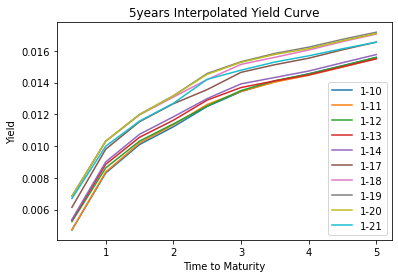

In [5]:
# calculate interpolation
def inter(a, b):
    x = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
    ls = []
    inter = interp1d(a, b, bounds_error=False)
    for i in x:
        value = float(inter(i))
        ls.append(value)
    return np.asarray(x), np.asarray(ls)


# interpolated yield curve
for i in range(len(data)):
    inter_res = inter(data[i]["x"], data[i]["yield"])
    plt.plot(inter_res[0], inter_res[1].squeeze(), label = labels[i])
    plt.legend(loc = 'best')
    plt.xlabel('Time to Maturity')
    plt.ylabel('Yield')
    plt.title('5years Interpolated Yield Curve')

In [ ]:
# calculate spot rate
def spot(df):
    npl = np.empty([1,10])
    for i, bond in df.iterrows():
        if i == 0:
            npl[0, i] = -np.log(bond["dirty price"] / (bond["coupon"] * 100 / 2 + 100)) / bond["x"]
        else:
            t = np.asarray([bond["coupon"] * 100 / 2] * i + [bond["coupon"] * 100 / 2 + 100])
            s = lambda y: np.dot(t[:-1],np.exp(-(np.multiply(npl[0,:i], df["x"][:i])))) + t[i] * np.exp(-y * bond["x"]) - bond["dirty price"]
            npl[0, i] = optimize.fsolve(s, .05)
    npl[0, 8] = (npl[0, 7] + npl[0, 9]) / 2
    return npl


# uninterpolated spot curve
for i in range(len(data)):
    plt.plot(data[i]["x"], spot(data[i]).squeeze(), label = labels[i])
    plt.legend(loc='best')
    plt.xlabel('Time to Maturity')
    plt.ylabel('Spot Rate')
    plt.title('5years Uninterpolated Spot Curve')

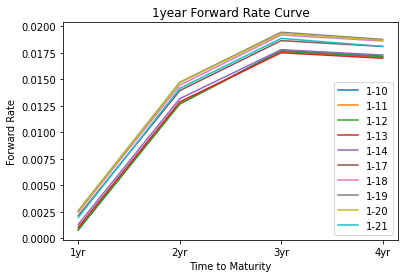

In [8]:
# calculate the forward rate
def forward(df):
    x, y = inter(df["x"], spot(df).squeeze())
    f1 = (y[3] * 2 - y[1] * 1)/(2-1)
    f2 = (y[5] * 3 - y[1] * 1)/(3-1)
    f3 = (y[7] * 4 - y[1] * 1)/(4-1)
    f4 = (y[9] * 5 - y[1] * 1)/(5-1)
    f = [f1,f2,f3,f4]
    return f

# forward curve
for i in range(len(data)):
    plt.plot(['1yr','2yr','3yr','4yr'], forward(data[i]), label = labels[i])
    plt.legend(loc = 'best')
    plt.xlabel('Time to Maturity')
    plt.ylabel('Forward Rate')
    plt.title('1year Forward Rate Curve')

In [9]:
# calculate covariance matrix
def cov(df):
    log = np.empty([5,9])
    npl = np.empty([5,10])
    for i in range(len(df)):
        x,y = inter(df[i]["x"], df[i]["yield"])
        npl[0,i] = y[1]
        npl[1,i] = y[3]
        npl[2,i] = y[5]
        npl[3,i] = y[7]
        npl[4,i] = y[9]
    for i in range(0, 9):
        log[0, i] = np.log(npl[0,i+1]/npl[0,i])
        log[1, i] = np.log(npl[1,i+1]/npl[1,i])
        log[2, i] = np.log(npl[2,i+1]/npl[2,i])
        log[3, i] = np.log(npl[3,i+1]/npl[3,i])
        log[4, i] = np.log(npl[4,i+1]/npl[4,i])
    return np.cov(log),log
print('covariance matrix')
print(cov(data)[0])

covariance matrix
[[0.00110276 0.00087735 0.00073205 0.00072817 0.00071021]
 [0.00087735 0.00076313 0.00063415 0.0006141  0.00060142]
 [0.00073205 0.00063415 0.00054988 0.00054178 0.00052788]
 [0.00072817 0.0006141  0.00054178 0.00057962 0.00056003]
 [0.00071021 0.00060142 0.00052788 0.00056003 0.00054562]]


In [10]:
def matrix(df):
    npl = np.empty([4,10])
    for i in range(len(df)):
        npl[:,i] = forward(df[i])
    return npl


print("covariance matrix: ", np.cov(matrix(data)))
print('-----------------------------------------------------------------------------------------------')
w1, v1 = LA.eig(np.cov(cov(data)[1]))
print("eigenvalue of the matrix :", w1)
print('------------------------------------------------------------------------------------------------')
print("eigenvector of the matrix is: ", v1)
print('-------------------------------------------------------------------------------------------------')
w2, v2 = LA.eig(np.cov(matrix(data)))
print("eigenvalue of the matrix :", w2)
print('-------------------------------------------------------------------------------------------------')
print("eigenvector of the matrix is: ", v2)

covariance matrix:  [[5.74094889e-07 6.52679431e-07 5.87986927e-07 5.42526792e-07]
 [6.52679431e-07 7.53279661e-07 6.81575141e-07 6.24269893e-07]
 [5.87986927e-07 6.81575141e-07 6.31398049e-07 5.78168216e-07]
 [5.42526792e-07 6.24269893e-07 5.78168216e-07 5.32482991e-07]]
-----------------------------------------------------------------------------------------------
eigenvalue of the matrix : [3.38469845e-03 1.01595005e-04 4.49627404e-05 7.64312613e-06
 2.11086273e-06]
------------------------------------------------------------------------------------------------
eigenvector of the matrix is:  [[-0.55679453 -0.63439341 -0.52679469 -0.09826218  0.01888787]
 [-0.46636184 -0.22506681  0.66075354  0.53473366 -0.09652067]
 [-0.39770763  0.12533854  0.42161101 -0.80189147  0.07302818]
 [-0.40155946  0.53995187 -0.26558988  0.08147922 -0.68558379]
 [-0.39123538  0.48952238 -0.19390277  0.23395655  0.71761324]]
----------------------------------------------------------------------------------